In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision
import numpy as np
import os
cwd = os.getcwd()
from PIL import Image
import time
import copy
import random
import cv2
import re
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
base_dir = cwd
Melanoma_train = base_dir + "/train/Melanoma/"
Melanoma_val = base_dir + "/val/Melanoma/"
NonMelanoma_train = base_dir + "/train/NonMelanoma/"
NonMelanoma_val = base_dir + "/val/NonMelanoma/"

Melanoma_files = os.listdir(Melanoma_train)
NonMelanoma_files = os.listdir(NonMelanoma_train)

In [3]:
print(len(Melanoma_files), len(NonMelanoma_files))

7992 7158


In [4]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

In [5]:
## Define data augmentation and transforms
chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=227),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(227),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [6]:
## Create the data loader
def load_dataset(format, batch_size):
    data_path = os.path.join(cwd, format)
    dataset = datasets.ImageFolder(
        root=data_path,
        transform= chosen_transforms[format]
    )
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        shuffle=True
    )
    return data_loader, len(dataset), dataset.classes

In [7]:
## Set code to run on device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
train_loader, train_size, class_names = load_dataset('train', 8)
print("Train Data Set size is: ", train_size)
print("Class Names are: ", class_names)
inputs, classes = next(iter(train_loader))
print(inputs.shape, classes.shape)

Train Data Set size is:  15150
Class Names are:  ['Negative', 'Positive']
torch.Size([8, 3, 227, 227]) torch.Size([8])


In [9]:
# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

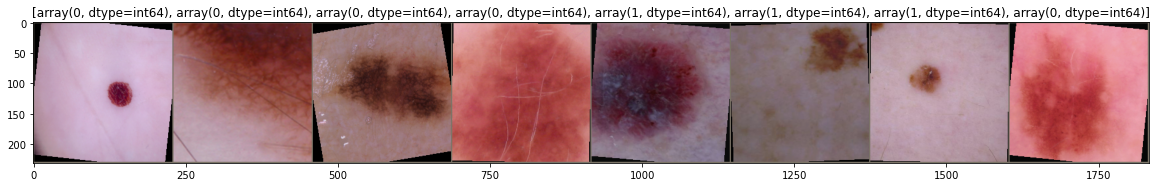

In [10]:
# visualize
inputs, classes = next(iter(train_loader))

out = torchvision.utils.make_grid(inputs)

idx_to_class = {0:'NonMelanoma', 1:'Melanoma'}
plt.figure(figsize=(20,10))
imshow(out, title=[x.data.numpy() for x in classes])

In [11]:
## Load pretrained model
resnet50 = models.resnet50(pretrained=True)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

## Change the final layer of the resnet model
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features
 
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 2)
)

# Convert model to be used on GPU
resnet50 = resnet50.to(device)



In [12]:
from torchsummary import summary
print(summary(resnet50, (3, 227, 227)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 114, 114]           9,408
       BatchNorm2d-2         [-1, 64, 114, 114]             128
              ReLU-3         [-1, 64, 114, 114]               0
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]           4,096
       BatchNorm2d-6           [-1, 64, 57, 57]             128
              ReLU-7           [-1, 64, 57, 57]               0
            Conv2d-8           [-1, 64, 57, 57]          36,864
       BatchNorm2d-9           [-1, 64, 57, 57]             128
             ReLU-10           [-1, 64, 57, 57]               0
           Conv2d-11          [-1, 256, 57, 57]          16,384
      BatchNorm2d-12          [-1, 256, 57, 57]             512
           Conv2d-13          [-1, 256, 57, 57]          16,384
      BatchNorm2d-14          [-1, 256,

In [13]:
# Define Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters())
# optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [14]:
dataloaders = {}
dataset_sizes = {}
batch_size = 256
dataloaders['train'], dataset_sizes['train'], class_names = load_dataset('train', batch_size)
dataloaders['val'], dataset_sizes['val'], _ = load_dataset('val', batch_size)
idx_to_class = {0:'NonMelanoma', 1:'Melanoma'}

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
                print('Training the model on Training data...')
            else:
                model.eval()   # Set model to evaluate mode
                print('Evaluating the model on validation data...')

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]
            if phase=='val' :
                val_history.append([epoch, epoch_loss, epoch_acc.item()])
                #print("val_history",val_history)
            else :
                train_history.append([epoch, epoch_loss, epoch_acc.item()])
                #print("train_history",train_history)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            

        

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print("Saving the best model with loss : ",best_loss, " & with accuracy : ",best_acc.item())
    torch.save(best_model_wts, './trained_models/Resnet50_Ep30_aug-trans.pkl')
    print("Saving the training and validation history.....")
    train_historynp = np.array(train_history)
    val_historynp = np.array(val_history)
    np.save('resnet50_aug_t_history.npy',train_historynp)
    np.save('resnet50_aug_v_history.npy',val_historynp)
    # load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [16]:
def visualize_model(model, num_images=60):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [17]:
base_model = train_model(resnet50, criterion, optimizer, exp_lr_scheduler, num_epochs=30)
#visualize_model(base_model)
#plt.show()

----------
Epoch 0/29
----------
Training the model on Training data...


C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.4753 Acc: 0.7728
Evaluating the model on validation data...
val Loss: 0.3539 Acc: 0.8454
----------
Epoch 1/29
----------
Training the model on Training data...
train Loss: 0.3096 Acc: 0.8701
Evaluating the model on validation data...
val Loss: 0.3483 Acc: 0.8493
----------
Epoch 2/29
----------
Training the model on Training data...
train Loss: 0.2839 Acc: 0.8825
Evaluating the model on validation data...
val Loss: 0.3308 Acc: 0.8603
----------
Epoch 3/29
----------
Training the model on Training data...
train Loss: 0.2787 Acc: 0.8850
Evaluating the model on validation data...
val Loss: 0.3164 Acc: 0.8617
----------
Epoch 4/29
----------
Training the model on Training data...
train Loss: 0.2818 Acc: 0.8824
Evaluating the model on validation data...
val Loss: 0.3175 Acc: 0.8623
----------
Epoch 5/29
----------
Training the model on Training data...
train Loss: 0.2716 Acc: 0.8890
Evaluating the model on validation data...
val Loss: 0.3129 Acc: 0.8595
----------
Epoch 6/29


In [ ]:
visualize_model(base_model)
plt.show()

In [ ]:
import numpy as np
np.load('resnet50_t_history.npy')

In [18]:
def predict(model, test_image, print_class = False):
     
    transform = chosen_transforms['val']
     
    test_image_tensor = transform(test_image)
 
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227)
     
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        
        pred = torch.max(out,1)
        #print("pred", pred)
        #print(out)
        ps = torch.exp(out)
        #print(ps)
        topk, topclass = ps.topk(1, dim=1)
        class_name = idx_to_class[topclass.cpu().numpy()[0][0]]
        if print_class:
            print("Output class :  ", class_name)
            #print(topk)
            #print(topclass)
    return class_name

In [19]:
import PIL
print("total val Melanoma images :",(len(os.listdir("val/Melanoma"))))
k = 0
for i in os.listdir("val/Melanoma") :
    img = PIL.Image.open("val/Melanoma/"+i)
    tclass = "Melanoma"
    pclass = predict(base_model,img)
    if tclass == pclass :
        k = k+1
print("predicted as Melanoma : " ,k)

import PIL
print("total val NonMelanoma images :",(len(os.listdir("val/NonMelanoma"))))
k = 0
for i in os.listdir("val/NonMelanoma") :
    img = PIL.Image.open("val/NonMelanoma/"+i)
    tclass = "NonMelanoma"
    pclass = predict(base_model,img)
    if tclass == pclass :
        k = k+1
print("predicted as NonMelanoma : " ,k)

total val positive images : 1807
predicted as positive :  1583
total val negative images : 1744
predicted as Negative :  1481


In [24]:
1807-1583
1744-1481

263

In [22]:
import PIL
print("total val NonMelanoma images :",(len(os.listdir("backup/val/NonMelanoma"))))
k = 0
for i in os.listdir("backup/val/NonMelanoma") :
    img = PIL.Image.open("backup/val/NonMelanoma/"+i)
    tclass = "NonMelanoma"
    pclass = predict(base_model,img)
    if tclass == pclass :
        k = k+1
print("predicted as NonMelanoma : " ,k)

total val negative images : 1744
predicted as Negative :  1659


In [23]:
import PIL
print("total val NonMelanoma images :",(len(os.listdir("backup/val/Melanoma"))))
k = 0
for i in os.listdir("backup/val/Melanoma") :
    img = PIL.Image.open("backup/val/Melanoma/"+i)
    tclass = "Melanoma"
    pclass = predict(base_model,img)
    if tclass == pclass :
        k = k+1
print("predicted as Melanoma : " ,k)

total val negative images : 225
predicted as Positive :  26


<AxesSubplot:>

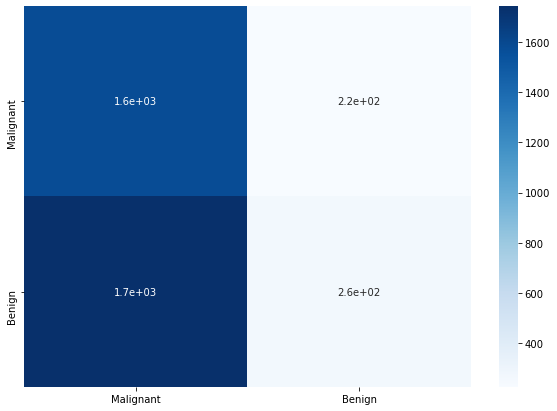

In [26]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[1583,224], 
        [1744,263]]
df_cm = pd.DataFrame(array, index = ['Malignant',"Benign"],
                  columns = ['Malignant',"Benign"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap='Blues')